In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm


from helpers.physics_functions import get_bins
from helpers.stats_functions import parametric_fit, curve_fit_m_inv, calculate_test_statistic
from helpers.evaluation import get_median_percentiles

from helpers.stats_functions import calculate_test_statistic
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Try to load LaTeX
latex_flag = False
np.seterr(divide='ignore')

# try:
#     plt.rc('text', usetex=True)
#     plt.rc('font', family='serif')
#     fig, ax = newplot("full", use_tex = True)
#     print("Loaded LaTeX")
#     latex_flag = True
# except:
#     print("Could not load LaTeX")
#     latex_flag = False  
# latex_flag = False

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [11]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 
    
feature_id = "mix_2"
bootstrap_flow = 0 # don't change this from 0

train_samesign = False
# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "SS"
else:
    train_data_id = "OS"

# train on opp sign means alt test set is samesign
if train_data_id == "OS": 
    alt_test_data_id = "SS"
elif train_data_id == "SS": 
    alt_test_data_id = "OS"

configs = "CATHODE_8"


# pickles contain all the results from the BDT training
working_dir = workflow["file_paths"]["working_dir"]
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data"
flow_training_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/models/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/{configs}/"
pickle_save_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/pickles/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/"
plot_data_dir = "plot_data/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 1
n_folds = 5

In [12]:
num_bins_SR = 12 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
bkg_fit_degree = 5

In [13]:
SB_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_left"])
SR_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_left"])
SR_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_right"])
SB_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_right"])

print(SB_left, SB_right)
print(SR_left, SR_right)


data_prefix = f"upsilon_{train_data_id}"
print(data_prefix)

5.0 16.0
9.0 10.6
upsilon_OS


# Load in the original data

In [14]:
# # load in the data corresponding to the train id
# # we actually want the "test band" here -- train is just for flow
# with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_{jet_id}_test_band_data", "rb") as infile: 
#     test_data_dict = pickle.load(infile)

# with open(f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}/seed1/configs.txt", "rb") as infile: 
#     configs = infile.readlines()[0].decode("utf-8")
    
#     feature_set = [x.strip() for x in configs.split("'")][1::2]

# print(f"Feature Set: {feature_set}")

## Load in the BDT results

In [15]:

print(f"Loading data from {flow_training_dir}")
with open(f"{flow_training_dir}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(f"Feature Set: {feature_set}")

Loading data from /global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_12_03/models/bootstrap0_OS/mix_2/CATHODE_8/
Feature Set: ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


In [16]:
# if train_samesign = False, this loads in the OS test data
# test 


def load_in_pseudoexperiments(file_string, num_pseudoexps):

    master_dict = {}

    with open(f"{pickle_save_dir}/{file_string}_{bkg_fit_degree}_{num_bins_SR}_0_1", "rb") as ifile:
        loc_dict = pickle.load(ifile)
    master_dict = {**loc_dict}
    # load in the bootstraps
    for i in range(1, num_pseudoexps):
        with open(f"{pickle_save_dir}/bkg_samples/bootstrap{i}/{file_string}_{bkg_fit_degree}_{num_bins_SR}_0_1", "rb") as ifile:
            loc_dict = pickle.load(ifile)
            master_dict[i] = loc_dict[0]
    return master_dict

num_to_plot = num_pseudoexperiments

all_test_data_splits = load_in_pseudoexperiments("all_test_data_splits", num_to_plot)
print(len(all_test_data_splits.keys())==num_pseudoexperiments)

# test scores
all_scores_splits = load_in_pseudoexperiments("all_scores_splits", num_to_plot)
print(len(all_scores_splits.keys())==num_pseudoexperiments)

# alt data
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
all_alt_data_splits = load_in_pseudoexperiments("all_alt_data_splits", num_to_plot)
print(len(all_alt_data_splits.keys())==num_pseudoexperiments)
# alt scores
all_alt_scores_splits = load_in_pseudoexperiments("all_alt_scores_splits", num_to_plot)

print(len(all_alt_scores_splits.keys())==num_pseudoexperiments)

with open(f"{processed_data_dir}/mass_scaler_bootstrap{bootstrap_flow}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
with open(f"{processed_data_dir}/preprocessing_info_bootstrap{bootstrap_flow}", "rb") as ifile:
     preprocessing_info = pickle.load(ifile)

True
True
True
True


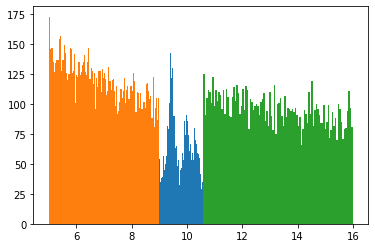

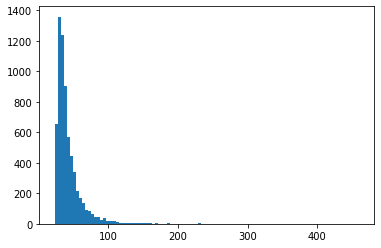

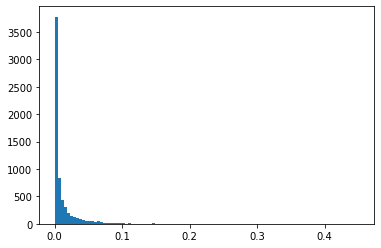

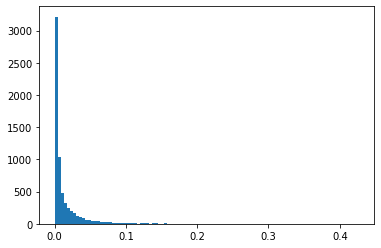

In [17]:
import pickle
import matplotlib.pyplot as plt

path_to_OS_data = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_12_03/processed_data/data_noIsoCut_noPreproc_OS_test_band_data"
with open(path_to_OS_data, "rb") as infile:
    data = pickle.load(infile)
    SR_data_OS = data["SR"]['skimmed_data_2016H_30555_nojet']
    SBL_data_OS = data["SBL"]['skimmed_data_2016H_30555_nojet']
    SBH_data_OS = data["SBH"]['skimmed_data_2016H_30555_nojet']




plt.figure()
plt.hist(SR_data_OS["dimu_mass"], bins = 100)
plt.hist(SBL_data_OS["dimu_mass"], bins = 100)
plt.hist(SBH_data_OS["dimu_mass"], bins = 100)
plt.show()

plt.figure()
plt.hist(SR_data_OS["dimu_pt"], bins = 100)
plt.show()

plt.figure()
plt.hist(SR_data_OS["mu0_ip3d"], bins = 100)
plt.show()

plt.figure()
plt.hist(SR_data_OS["mu1_ip3d"], bins = 100)
plt.show()

# Save the SR data
with open(f"{plot_data_dir}{data_prefix}_SR_data_OS.pickle", "wb") as ofile:
    pickle.dump(SR_data_OS, ofile)



## Plot histograms for a small number of FPR thresholds

In [18]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]


# Save the FPR thresholds
with open(f"{plot_data_dir}{data_prefix}_fpr_thresholds", "wb") as ofile:
    pickle.dump(fpr_thresholds, ofile)

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff

In [19]:
def plot_upsilon_resonances(ax):

    
    # plot the upsilon resonances
    ax.axvline(9.460, color="black", linestyle="--", alpha=0.15)
    # ax.text(9.460 * 0.995, 1e4, r"$\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.023, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.023 * 0.995, 1e4, r"$\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.355, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.355 * 0.995, 1e4, r"$\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.580, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.580 * 0.995, 1e4, r"$\Upsilon(4S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    # ax.axvline(11.020, color="black", linestyle="--", alpha=0.15)
    # ax.text(11.020 * 0.995, 1e4, r"$\Upsilon(5S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)

In [20]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, 
                              mass_scalar, fit_degree, title, SB_left, SR_left, SR_right, SB_right, 
                              n_folds= 5, take_score_avg=True,):
    




    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["fit_degree"] = fit_degree
    save_data["num_bins_SR"] = num_bins_SR
    save_data["popts"] = []
    save_data["pcovs"] = []
    save_data["significances"] = []
    save_data["filtered_masses"] = []
    save_data["y_vals"] = []


    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    # Get a list of all possible cuts for the feature


    all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
    all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
    all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
    in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
    in_SBL = (all_masses < SR_left )
    in_SBH = (all_masses > SR_right )

    mass_SBL = all_masses[in_SBL]
    mass_SR = all_masses[in_SR]
    mass_SBH = all_masses[in_SBH]

    feature_SBL = all_scores[in_SBL]
    feature_SR = all_scores[in_SR]
    feature_SBH = all_scores[in_SBH]

    feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)
    

        # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
        num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
        num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))




    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)



    for t, threshold in enumerate(fpr_thresholds):
        

                    # Use interpolation to find the cut point that gives the desired FPR
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]


        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

        # Concatenate to get the full mass spectrum
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)

        
        # plot the fit function
        plt.plot(plot_centers_all, parametric_fit(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, parametric_fit, [SB_left, SB_right], popt, pcov, color = f"C{t}")
        # calculate significance of bump
        S, B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = fit_degree, starting_guess = popt)


        total_events = len(filtered_masses)



        label_string = str(round(100*threshold, 2))+"% FPR: "+str(total_events)+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


        save_data["popts"].append(popt)
        save_data["pcovs"].append(pcov)
        save_data["significances"].append(np.sqrt(q0))
        save_data["filtered_masses"].append(filtered_masses)
        save_data["y_vals"].append(y_vals)



    line1 = f"{num_bins_SR -1 } Bins in SR"
    line2 = f"Fit Type: {fit_degree}-degree Polynomial"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"~6% of Original Data"

    starting_x = 0.05
    starting_y = 0.8
    delta_y = 0.04
    text_alpha = 0.75
    ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


    legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"
    plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    # plt.ylim(0.5, 1e3)
    plt.ylim(0.01, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    plot_upsilon_resonances(ax)


    # Do the thing for the pre-isolation data
    filtered_masses = np.concatenate((SR_data_OS["dimu_mass"], SBL_data_OS["dimu_mass"], SBH_data_OS["dimu_mass"]))

    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
    #print("chi2/dof:", chi2/n_dof)

    
    # plot the fit function
    plt.plot(plot_centers_all, parametric_fit(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"black")    
    function_with_band(ax, parametric_fit, [SB_left, SB_right], popt, pcov, color = f"black")
    S, B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = fit_degree, starting_guess = popt)
    
    total_events = len(filtered_masses)
    label_string = "Pre-cut; "+str(total_events)+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))
    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"black",label = label_string, alpha = 0.75)
    plt.scatter(plot_centers_SB, y_vals, color = f"black")

    save_data["popts"].append(popt)
    save_data["pcovs"].append(pcov)
    save_data["significances"].append(np.sqrt(q0))
    save_data["filtered_masses"].append(filtered_masses)
    save_data["y_vals"].append(y_vals)
    
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    # plt.title(title, fontsize = 24)
    return save_data
    


Saved Data to plot_data/upsilon_OS_histogram_data_5_12.pickle


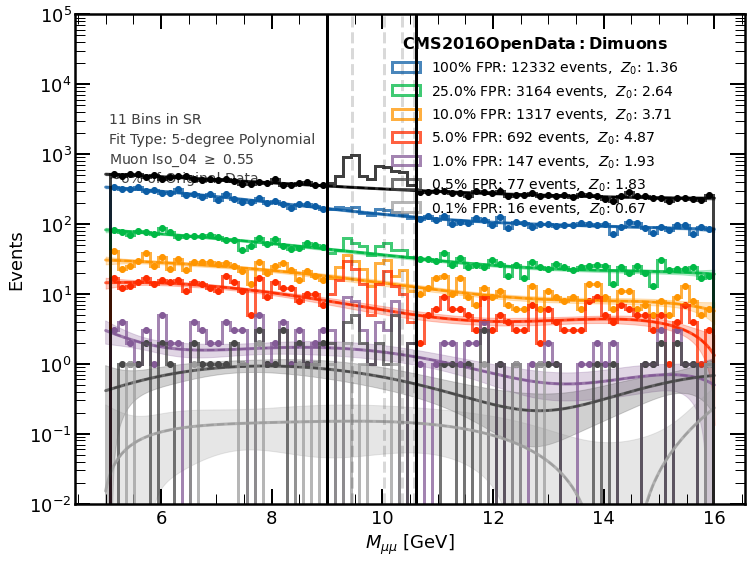

In [21]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
pseudo_e_to_plot = 0
save_data = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, bkg_fit_degree,f"upsilon OS\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)

print("Saved Data to " + f"{plot_data_dir}{data_prefix}_histogram_data_{bkg_fit_degree}_{num_bins_SR}.pickle")

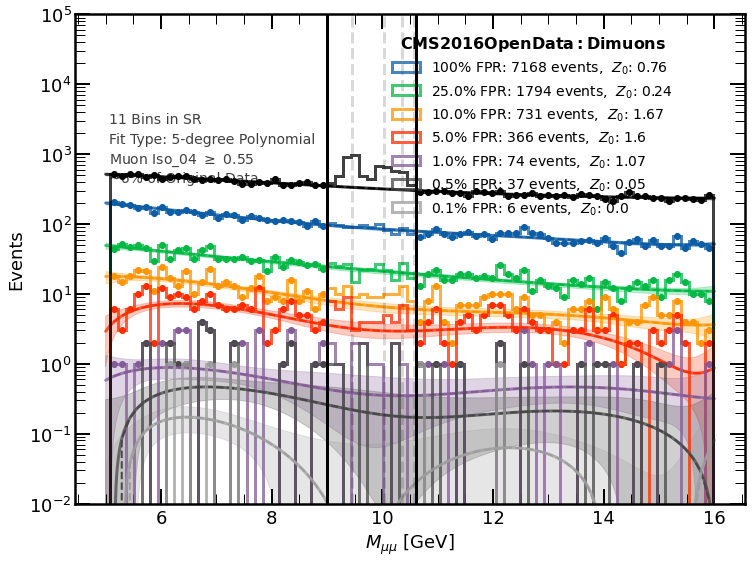

In [22]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
save_data = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], 
                                      all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], 
                                      scaler, bkg_fit_degree, f"upsilon SS",SB_left, SR_left, SR_right, SB_right, 
                                      take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_alt_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)


In [23]:
"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
# this plot won't be shown in the main body -- this is just the high-stats set that is used to create the ROC curve

#plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)



'\nPLOT HISTOGRAM ON ROC TEST DATA\n'

In [24]:
# """
# PLOT HISTOGRAM ON FLOW SAMPLES
# """
# plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


# Feature Plots

In [25]:
from helpers.data_transforms import scaled_to_physical_transform

def plot_features(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, SR_left, SR_right, n_folds= 5, take_score_avg=True):



    pre_isoation_cut_data = SR_data_OS

    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["features"] = []

    n_features = len(feature_set) - 1
    nbins = 40

    bins = {
        "dimu_pt": np.linspace(0, 150, nbins),
        "mu0_ip3d": np.logspace(-6, 0, nbins),
        "mu1_ip3d": np.logspace(-6, 0, nbins),
    }
    labels = {
        "dimu_pt": "Dimuon $p_T$ [GeV]",
        "mu0_ip3d": "Muon 1 IP3D [cm]",
        "mu1_ip3d": "Muon 2 IP3D [cm]",
    }


    all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
    all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
    all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))

    all_features = {i:all_data[:,i] for i in range(n_features)}
    all_features = {i: scaled_to_physical_transform(all_features[i], preprocessing_info[feature_set[i]], cushion = 0.02).reshape(-1,1) for i in range(n_features)}
    

    in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
    in_SBL = (all_masses < SR_left )
    in_SBH = (all_masses > SR_right )

    mass_SBL = all_masses[in_SBL]
    mass_SR = all_masses[in_SR]
    mass_SBH = all_masses[in_SBH]

    feature_SBL = all_scores[in_SBL]
    feature_SR = all_scores[in_SR]
    feature_SBH = all_scores[in_SBH]

    feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)
    

        # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
        num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
        num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))


    
    
    fig, ax = plt.subplots(1, n_features, figsize = (5*n_features, 5))


    for i_feat in range(n_features):

        ax[i_feat].hist(pre_isoation_cut_data[feature_set[i_feat]], bins=bins[feature_set[i_feat]], lw = 3, histtype = "step", color = "black",label = "Pre-Isolation Cut", alpha = 0.75)


    
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_features = {i:[] for i in range(n_features)}

        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

        for i_feat in range(n_features):

            # Apply the cut
            indices = (in_SR) & (all_scores >= best_feature_cut)
            print(indices.shape)
            filtered_features[i_feat] = all_features[i_feat][indices]

            # Get only the SR

        # # for each fold, select the events that meet the fpr threshold
        # for i_fold in range(n_folds):
        #     if take_score_avg:
        #         loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
        #     else:
        #         loc_scores = scores_dict_by_fold[i_fold]
                
        #     loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
                 
        #     loc_in_SR_indices =  (loc_true_masses >= SR_left) & (loc_true_masses <= SR_right) 
        #     loc_score_indices = (loc_scores >= score_cutoffs_by_fold[i_fold][threshold])
            
        #     loc_pass_indices = loc_in_SR_indices.reshape(-1,) & loc_score_indices.reshape(-1,)
            
        #     for i_feat in range(n_features):
        #         # undo the scaling
        #         selected_features = scaled_to_physical_transform(data_dict_by_fold[i_fold][:,i_feat], preprocessing_info[feature_set[i_feat]], cushion = 0.02)
        #         filtered_features[i_feat].append(selected_features[loc_pass_indices])
                
        # for i_feat in range(n_features):
        #     filtered_features[i_feat] = np.concatenate(filtered_features[i_feat])   

        save_data["features"].append(filtered_features)

        for i_feat in range(n_features):

            label_string = str(round(100*threshold, 2))+"% FPR"
            


            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
            ax[i_feat].set_yscale("log")
            if i_feat in [1, 2]:
                ax[i_feat].set_xscale("log")
                ax[i_feat].set_xticks([1e-3, 1e-2, 1e-1])
            ax[i_feat].set_xlabel(labels[feature_set[i_feat]])
            ax[i_feat].set_ylim(1e-1, 5*1e3)

            ax[i_feat].tick_params(labelsize = 16)

            if i_feat > 0:
                ax[i_feat].set_yticklabels([])


           

    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    plt.legend(loc = (1.05, 0.4), fontsize = 16)

    ax[0].set_ylabel("Events", fontsize = 18)
    plt.subplots_adjust(wspace=0)
    return save_data

(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)
(12332, 1)


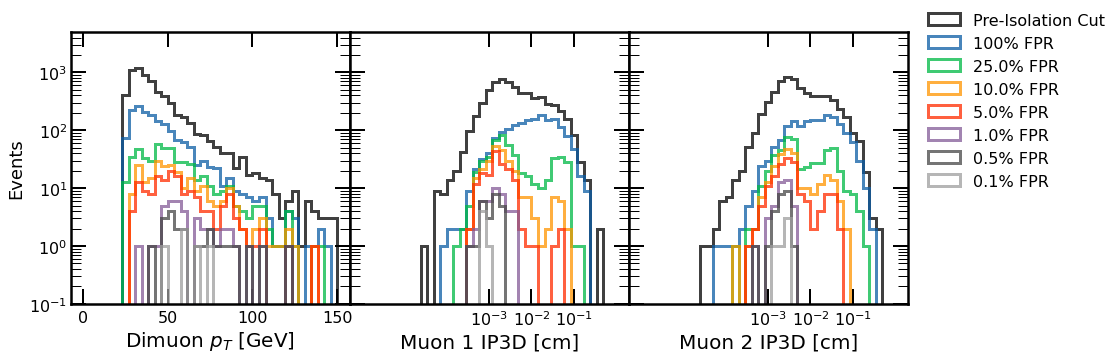

In [26]:
save_data = plot_features(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, SR_left, SR_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_feature_data_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)

In [27]:
def plot_features(save_data, colors, alphas):


    fpr_thresholds = save_data["fpr_thresholds"]
    filtered_features_all = save_data["features"]


    n_features = len(feature_set) 
    nbins = 50

    bins = {
        "dimu_pt": np.linspace(0, 150, nbins),
        "mu0_ip3d": np.logspace(-4, 0, nbins),
        "mu1_ip3d": np.logspace(-4, 0, nbins),
    }
    labels = {
        "dimu_pt": "Dimuon $p_T$ [GeV]",
        "mu0_ip3d": "Muon 1 IP3D [cm]",
        "mu1_ip3d": "Muon 2 IP3D [cm]",
    }

    
    
    fig, ax = newplot("column", width = 9, height = 3, subplot_array=(1, n_features))
    # fig, ax = plt.subplots(1, n_features, figsize = (9, 3))
    
    for t, threshold in enumerate(fpr_thresholds):

        filtered_features = filtered_features_all[t]
        
   
        for i_feat in range(n_features):

            label_string = str(round(100*threshold, 2))+"\% FPR"


            

            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 2, histtype = "step", color = colors[t],label = label_string, alpha = alphas[t])
            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 2, histtype = "stepfilled", color = colors[t], alpha = 0.03)
            ax[i_feat].set_yscale("log")

            if i_feat == 0:
                ax[i_feat].set_xlim(10, 150)
                ax[i_feat].set_xticks([0, 50, 100, 150])

            if i_feat in [1, 2]:
                ax[i_feat].set_xscale("log")
                ax[i_feat].set_xticks([1e-3, 1e-2, 1e-1])
            ax[i_feat].set_xlabel(labels[feature_set[i_feat]])
            ax[i_feat].set_ylim(5e-1, 1e3)

            ax[i_feat].tick_params(labelsize = 16)

            if i_feat > 0:
                ax[i_feat].set_yticklabels([])

    starting_x = 0.075
    starting_y = 0.955
    delta_y = 0.05
    text_alpha = 0.75

    line0 = r"Opposite Sign: $\mu^+\mu^-$"
    line1 = f"Bin width = {bin_percent[num_bins_SR]}\%"
    line2 = f"Fit Type: {bkg_fit_degree}"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"16.4fb$^{-1}$, $\sqrt{s} = 13$ TeV"

    if line0 is not None:
        ax[1].text(starting_x, starting_y - (0) * delta_y, r"$\texttt{HLT\_TrkMu15\_DoubleTrkMu5NoFiltersNoVt}$", transform=ax[1].transAxes, fontsize=7, verticalalignment='top', alpha = text_alpha, zorder = 10)
        ax[1].text(starting_x, starting_y - (1) * delta_y, line0, transform=ax[1].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)

    ax[2].text(starting_x, starting_y - 0 * delta_y, line1, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[2].text(starting_x, starting_y - 1 * delta_y, line2, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[2].text(starting_x, starting_y - 2 * delta_y, line3, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[2].text(starting_x, starting_y - 3 * delta_y, line4, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)

    title = r"$\bf{ 2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon}$"
    plt.title(title, fontsize = 10, loc = "right")
           

    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    ax[0].legend(loc = "upper right", fontsize = 8)

    ax[0].set_ylabel("Events", fontsize = 18)
    plt.subplots_adjust(wspace=0)



    return save_data2

# Classical Studies

In [28]:
# from helpers.plotting import feature_bins


# def plot_feature_cuts(feature, fpr_thresholds, test_data_dict, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False):
#     """
#     Plot the feature cuts for the given data, scores, and score cutoffs.

#     Parameters
#     ----------
#     feature : str
#         The feature to plot the cuts for.
#     fpr_thresholds : list
#         The list of FPR thresholds to plot.
#     test_data_dict : dict
#         The dictionary of test data.
#     mass_scalar : sklearn.preprocessing.StandardScaler
#         The mass scaler.
#     fit_type : str
#         The type of fit to use for the background.
#     title : str
#         The title of the plot.
#     SB_left : float
#         The left side of the sideband.
#     SR_left : float
#         The left side of the signal region.
#     SR_right : float
#         The right side of the signal region.
#     SB_right : float
#         The right side of the sideband.
#     """

        
#     save_data = {}
#     save_data["fpr_thresholds"] = fpr_thresholds
#     save_data["fit_type"] = fit_type
#     save_data["num_bins_SR"] = num_bins_SR
#     save_data["popts"] = []
#     save_data["pcovs"] = []
#     save_data["significances"] = []
#     save_data["filtered_masses"] = []
#     save_data["y_vals"] = []

#     # Unpack the data dictionary to extract the feature of interest 
#     feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
#     feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
#     feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

#     if flip:
#         feature_SBL = -feature_SBL
#         feature_SR = -feature_SR
#         feature_SBH = -feature_SBH

#     # Unpack the data dictionary to extract the dimuon mass spectrum
#     mass_SBL = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
#     mass_SR = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
#     mass_SBH = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))

#     # Get a list of all possible cuts for the feature
#     feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

#     # For each cut, calculate the number of signal and background events in the SR
#     num_in_SBL = []
#     num_in_SR = []
#     num_in_SBH = []
#     FPR = []
#     for cut in feature_cut_points:
#         num_in_SBL.append(np.sum(feature_SBL >= cut))
#         num_in_SR.append(np.sum(feature_SR >= cut))
#         num_in_SBH.append(np.sum(feature_SBH >= cut))


#         # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
#         # FPR is the combination of SBH and SBL
#         FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
#     # Set up fit types
#     if fit_type == "cubic": fit_function = bkg_fit_cubic
#     elif fit_type == "quintic": fit_function = bkg_fit_quintic
#     elif fit_type == "septic": fit_function = bkg_fit_septic

#     plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

#     fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


#     # fig, ax = newplot("full", aspect_ratio = 1.5)
#     fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
#     for t, threshold in enumerate(fpr_thresholds):


#         # Use interpolation to find the cut point that gives the desired FPR
#         best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

#         # Make the cuts to both the feature and the mass
#         feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
#         feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
#         feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

#         mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
#         mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
#         mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

#         # Concatenate to get the full mass spectrum
#         filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
        

#         # get the fit function to SB background
#         # popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv_CLASSICAL(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_SR, plot_bins_right, plot_centers_all)
#         popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
#         #print("chi2/dof:", chi2/n_dof)
        
#         # plot the fit function
#         plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    

#         # calculate significance of bump
#                 # calculate significance of bump
#         if ONE_SIDED:
#             num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, ONE_SIDED)
#             q0 = calculate_test_statistic(filtered_masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)


#             y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
#             B_error = np.sqrt(np.sum(y_err**2))
#             S_over_B = num_S_expected_in_SR/num_B_expected_in_SR

            

#         label_string = str(round(100*threshold, 2))+"% FPR: "+str(len(feature_SBL_cut)+len(feature_SR_cut)+len(feature_SBH_cut))+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))


#         hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string, alpha_1 = 0.1, alpha_2 = 0.5)
#         # plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
#         plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


#         save_data["popts"].append(popt)
#         save_data["pcovs"].append(pcov)
#         save_data["significances"].append(np.sqrt(q0))
#         save_data["filtered_masses"].append(filtered_masses)
#         save_data["y_vals"].append(y_vals)

#     line1 = f"{num_bins_SR -1 } Bins in SR"
#     line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
#     line3 = r"Muon Iso_04 $\geq$ 0.55"
#     line4 = r"~6% of Original Data"

#     starting_x = 0.475
#     starting_y = 0.45
#     delta_y = 0.04
#     text_alpha = 0.75
#     ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
#     ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
#     ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
#     ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


#     legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$: "+feature
#     plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


#     plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
#     plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

#     plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
#     plt.ylabel("Events", fontsize = 18)

#     # plt.yscale("log")
#     plt.ylim(0.5, 1e3)

#     # Add more x ticks (major and minor)
#     plt.xticks(fontsize = 18)
#     plt.yticks(fontsize = 18)
#     plt.minorticks_on()
#     plt.tick_params(axis='x', which='minor', bottom=True)
#     plt.tick_params(axis='y', which='minor', left=True)

#     plot_upsilon_resonances(ax)

#     return save_data


In [29]:
# flip_features = [False, True, True]
# for feature in feature_set[:-1]:
#     print(feature)
#     save_data =  plot_feature_cuts(feature, fpr_thresholds, test_data_dict, scaler, fit_type, f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})", SB_left, SR_left, SR_right, SB_right, flip = flip_features[feature_set.index(feature)])
#     with open(f"{plot_data_dir}{data_prefix}_feature_cut_data_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
#         pickle.dump(save_data, ofile)


In [34]:
n_folds = 5

"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -3, 25)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff



n_folds = 5

"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff


        
def get_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, mass_scalar):

    num_experiments = num_pseudoexperiments
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))
    significances = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))


    for pseudo_e in range(num_experiments):

        data_dict_by_fold = dataset_by_pseudo_e[pseudo_e]
        scores_dict_by_fold = scores_by_pseudo_e[pseudo_e]

        all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
        all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
        all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
        in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
        in_SBL = (all_masses < SR_left )
        in_SBH = (all_masses > SR_right )

        mass_SBL = all_masses[in_SBL]
        mass_SR = all_masses[in_SR]
        mass_SBH = all_masses[in_SBH]

        feature_SBL = all_scores[in_SBL]
        feature_SR = all_scores[in_SR]
        feature_SBH = all_scores[in_SBH]
        
        # Get a list of all possible cuts for the feature
        feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)

         # For each cut, calculate the number of signal and background events in the SR
        num_in_SBL = []
        num_in_SR = []
        num_in_SBH = []
        FPR = []
        for cut in feature_cut_points:
            num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
            num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
            num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))



        print(f"On pseudo experiment {pseudo_e+1}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]


            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

             # calculate significance of bump
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, bkg_fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            S,B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = bkg_fit_degree, starting_guess = popt, verbose_plot = False)
            print("S: ", S, "B: ", B, "sqrt(q0): ", np.sqrt(q0))

            significances[t, pseudo_e] = np.sqrt(q0)

        
    
    return significances



In [35]:
test = all_alt_data_splits[0]["alt"][0]
print(test)

test = all_test_data_splits[0]
print(test.keys())

[[-0.36103812 -0.28127673 -0.31624714 -1.12869668]
 [-0.38133496 -0.35850218 -0.21336173 -0.49877056]
 [-0.67608297  0.37362695 -1.20124292 -0.79122913]
 ...
 [ 0.39493492 -0.20762438 -0.79661554 -0.85346329]
 [ 0.75555509  1.5010978  -0.16470049 -0.96724528]
 [-0.25863266  0.17462561  1.64709949 -0.90186012]]
dict_keys([0, 1, 2, 3, 4])


In [36]:
# Reformat alt to not have the 'alt' key
all_alt_data_splits_formatted = {}
all_alt_scores_splits_formatted = {}
for pseudo_e in range(num_pseudoexperiments):
    all_alt_data_splits_formatted[pseudo_e] = all_alt_data_splits[pseudo_e]["alt"]
    all_alt_scores_splits_formatted[pseudo_e] = all_alt_scores_splits[pseudo_e]["alt"]


print(all_scores_splits.keys())

dict_keys([0])


In [37]:
significances = get_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, scaler)
with open(f"{plot_data_dir}{data_prefix}_significances_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances, ofile)


significances_alt = get_classifier_metrics_high_stats(all_alt_data_splits_formatted, all_alt_scores_splits_formatted, scaler)
with open(f"{plot_data_dir}{data_prefix}_significances_alt_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances_alt, ofile)




On pseudo experiment 1...
S:  83.90820222813863 B:  1608.0917977718614 sqrt(q0):  1.356272968221533
S:  97.59785001160662 B:  1227.4021499883934 sqrt(q0):  1.798959927085239
S:  94.30064673262393 B:  937.6993532673761 sqrt(q0):  1.9836088332045025
S:  110.22978108648351 B:  694.7702189135165 sqrt(q0):  2.6602334958308957
S:  74.37118081726578 B:  540.6288191827342 sqrt(q0):  2.0591555940555484
S:  79.77290154952118 B:  399.2270984504788 sqrt(q0):  2.537932649149876
S:  82.99847749788034 B:  301.00152250211966 sqrt(q0):  2.9975590741374836
S:  81.1379189922194 B:  225.8620810077806 sqrt(q0):  3.327526780217744
S:  80.3876564740913 B:  172.6123435259087 sqrt(q0):  3.711030081316445
S:  88.8500678631284 B:  126.1499321368716 sqrt(q0):  4.597991917225586
S:  78.31937842323894 B:  98.68062157676106 sqrt(q0):  5.252148821092203
S:  64.33556365106142 B:  72.66443634893858 sqrt(q0):  4.281138018591133
S:  49.890777689323706 B:  57.109222310676294 sqrt(q0):  3.756610497867892
S:  52.08542426862

In [38]:
from helpers.plotting import feature_bins


def feature_cut_ROCS(feature, test_data_splits, mass_scalar, fit_degree, title, SB_left, SR_left, SR_right, SB_right, flip = False, index = 0, random = False):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """
    num_experiments = num_pseudoexperiments
    fpr_thresholds = fpr_thresholds_finegrained
    S_yield = np.zeros((len(fpr_thresholds), num_experiments))
    B_yield = np.zeros((len(fpr_thresholds), num_experiments))
    background_errors = np.zeros((len(fpr_thresholds), num_experiments))
    significances = np.zeros((len(fpr_thresholds), num_experiments))



    for (e, pseudo_e) in enumerate(tqdm(range(num_experiments))):

        all_nfolds = np.concatenate([test_data_splits[pseudo_e][i] for i in range(n_folds)])
        

        if random:
            feature_of_interest = np.random.uniform(0, 1, len(all_nfolds[:,-1]))
        else:
            feature_of_interest = all_nfolds[:,index]

        # mean = np.nanmean(feature_of_interest)
        # feature_of_interest = np.nan_to_num(feature_of_interest, nan = mean)

        masses = mass_scalar.inverse_transform(np.array(all_nfolds[:,-1]).reshape(-1,1))[:,0]

        # mean = np.nanmean(masses)
        # masses = np.nan_to_num(masses, nan = mean)

        if flip:
            feature_of_interest = -feature_of_interest
           

        # Split into SBL, SR, and SBH
        # print(masses.shape, feature_of_interest.shape)
        feature_SBL = feature_of_interest[masses < SR_left]
        feature_SR = feature_of_interest[(masses >= SR_left) & (masses <= SR_right)]
        feature_SBH = feature_of_interest[masses > SR_right]




        # Get a list of all possible cuts for the feature
        mass_SBL = masses[masses < SR_left]
        mass_SR = masses[(masses >= SR_left) & (masses <= SR_right)]
        mass_SBH = masses[masses > SR_right]

        # print(mass_SBL.shape, mass_SR.shape, mass_SBH.shape)
        # print(feature_SBL.shape, feature_SR.shape, feature_SBH.shape)

        feature_cut_points = np.linspace(np.min(feature_of_interest), np.max(feature_of_interest), 10000)

        FPR = []
        for cut in feature_cut_points:
            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))



        plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)
        fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}



        # fig, ax = newplot("full", aspect_ratio = 1.5)
        for t, threshold in enumerate(fpr_thresholds):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]
            # print(np.min(feature_of_interest), np.max(feature_of_interest), best_feature_cut)

            # Make the cuts to both the feature and the mass
            feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
            feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
            feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

    

            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]


            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

            # calculate significance of bump
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
           
            S,B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = fit_degree, starting_guess = popt, verbose_plot = False)
            print("S: ", S, "B: ", B, "sqrt(q0): ", np.sqrt(q0))

            significances[t, pseudo_e] = np.sqrt(q0)

    
    return significances


In [39]:


for i in range(n_folds):
    all_test_data_splits[pseudo_e][i][:,0] = all_test_data_splits[pseudo_e][i][:,1] + all_test_data_splits[pseudo_e][i][:,2]

In [40]:

feature_SIGs = {}
feature_SIGs_alt = {}

flip_features = [True, True, True, False] 



#"dimu_pt", "mu0_ip3d", "mu1_ip3d", 
for (i, feature) in enumerate(["dimu_pt", ]):
# for (i, feature) in enumerate(["dimu_pt"]):
    print(feature)
    feature_SIGs[feature] = feature_cut_ROCS(feature, all_test_data_splits, scaler, bkg_fit_degree, f"", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_{feature}_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs[feature], ofile)

  
for (i, feature) in enumerate(["dimu_pt"]):
# for (i, feature) in enumerate(["dimu_pt"]):
    print(feature)
    feature_SIGs_alt[feature] = feature_cut_ROCS(feature, all_alt_data_splits_formatted, scaler, bkg_fit_degree, f"", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_alt_{feature}_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs_alt[feature], ofile)

  


  0%|          | 0/1 [00:00<?, ?it/s]

dimu_pt
S:  83.90820222813863 B:  1608.0917977718614 sqrt(q0):  1.356272968221533
S:  133.50281732968938 B:  1196.4971826703106 sqrt(q0):  2.468748029209779
S:  152.8375193205992 B:  875.1624806794008 sqrt(q0):  3.2480234341372083
S:  130.85078320254252 B:  658.1492167974575 sqrt(q0):  3.1959891709619237
S:  116.04236567734523 B:  495.95763432265477 sqrt(q0):  3.2472687097477766
S:  128.82414346524314 B:  376.17585653475686 sqrt(q0):  4.061163539711807
S:  127.93120295147213 B:  289.06879704852787 sqrt(q0):  4.535536859600843
S:  117.27513227525745 B:  201.72486772474255 sqrt(q0):  4.808262945730204
S:  107.3852546522275 B:  152.6147453477725 sqrt(q0):  5.009790709756836
S:  99.91407285302623 B:  113.08592714697377 sqrt(q0):  5.319677082200125
S:  81.22924857103241 B:  87.77075142896759 sqrt(q0):  4.869143470581465
S:  76.81583481362668 B:  65.18416518637332 sqrt(q0):  5.154022092625257
S:  58.57196438183347 B:  47.42803561816653 sqrt(q0):  4.553980733121963
S:  40.367094166976024 B:  

  0%|          | 0/1 [00:00<?, ?it/s]

S:  3.917794984086028 B:  3.082205015913972 sqrt(q0):  1.9100058964580546
dimu_pt
S:  35.94921060180741 B:  953.0507893981926 sqrt(q0):  0.7564721854544897
S:  39.94621237483659 B:  658.0537876251634 sqrt(q0):  1.0726933166763983
S:  39.07910054019413 B:  471.92089945980587 sqrt(q0):  1.1401807271530562
S:  49.693255472742464 B:  339.30674452725754 sqrt(q0):  1.6789322352727651
S:  25.862016650425176 B:  259.1379833495748 sqrt(q0):  1.0117499016961347
S:  2.0423858521569116 B:  204.9576141478431 sqrt(q0):  0.09245727505418197
S:  14.072291138700876 B:  138.92770886129912 sqrt(q0):  0.7439701692059654
S:  9.95380208471289 B:  101.04619791528711 sqrt(q0):  0.6226685512590199
S:  -5.7695168174460605 B:  82.76951681744606 sqrt(q0):  0.0
S:  2.991864201128088 B:  57.00813579887191 sqrt(q0):  0.5540198171419289
S:  6.086695764344547 B:  38.91330423565545 sqrt(q0):  0.6454902059753431
S:  5.737531752289566 B:  27.262468247710434 sqrt(q0):  0.6755387084787908
S:  3.294211571107784 B:  18.70578

100%|██████████| 1/1 [01:49<00:00, 109.90s/it]

S:  -0.04706585816670601 B:  0.04706585816670601 sqrt(q0):  0.0


In [41]:
# Add the ordinary TPR, FPR, ROC, SIC to dictionary with key "CATHODE"
feature_SIGs["CATHODE"] = significances
feature_SIGs_alt["CATHODE"] = significances_alt


[1.35627297 2.46874803 3.24802343 3.19598917 3.24726871 4.06116354
 4.53553686 4.80826295 5.00979071 5.31967708 4.86914347 5.15402209
 4.55398073 3.59272604 3.22624567 3.91972343 3.67545049 4.69209442
 4.41875198 2.90908331 3.19510233 3.22468506 2.49409637 2.55300378
 1.9100059 ]
max observed significance 5.319677082200125


KeyError: 'mu0_ip3d'

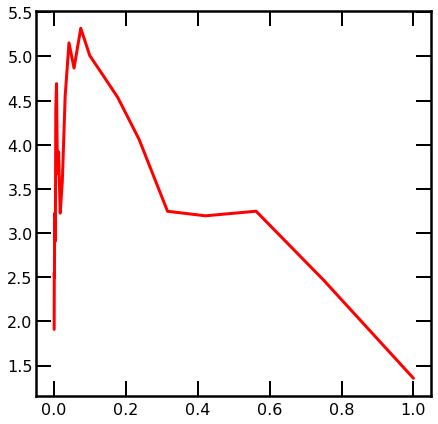

In [42]:



# FPR Variant of SIC
fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue"]
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs[key][:,0]
    print(SIG_observed)
    # SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs[key][:,1:])
    # # SIG_median = SIG_observed
    # # SIG_lower = SIG_observed
    # # SIG_upper = SIG_observed
    # # SIG_2lower = SIG_observed
    # # SIG_2upper = SIG_observed

    # print(key)
    # index = 0
    # print("max observed significance", np.max(SIG_observed))
    # print("Original Significance", SIG_observed[index])
    # print("Median significance", SIG_median[index])
    # print("+1sigma significance", SIG_lower[index], SIG_upper[index])
    # print("+2sigma significance", SIG_2lower[index], SIG_2upper[index])

    # print("Percent of 0", np.sum(feature_SIGs[key][index,1:] == 0)/len(feature_SIGs[key][index,1:]))
    

    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    # ax.plot(fpr_thresholds_finegrained, SIG_median, color = colors[i], linestyle = "dashed", alpha = 0.5)
    # ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = colors[i])
    # ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = colors[i])

    print("max observed significance", np.max(SIG_observed))

# Artificially make a legend
# plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys()) 
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")


# Add the keys in a seperate column with filled color
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):
    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")


# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs["random"][:,0]
# SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {bkg_fit_degree} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r""

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)
plt.xscale("log")
plt.ylim(0.0, 10)
# plt.yscale("log")

# ax.plot(FPR_median, SIC_median, color = "black", label = r"CATHODE")
# ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
# ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
# ax.set_xlabel("FPR")
# ax.set_ylabel("Signifance Improvement")

# legend_title = "Original Signifiance = {###}"
# plt.legend(title = legend_title, loc = "upper right")
# plt.xscale("log")
# plt.ylim(0, 6)

KeyError: 'mu0_ip3d'

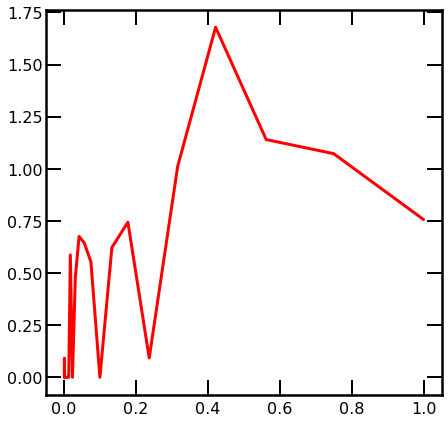

In [43]:
# same plot but for the alternative data

fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue", "black"]

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs_alt[key][:,0]
    # SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs_alt[key][:,1:])
    # SIG_median = SIG_observed
    # SIG_lower = SIG_observed
    # SIG_upper = SIG_observed
    # SIG_2lower = SIG_observed
    # SIG_2upper = SIG_observed
    


    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    if key == "random":
        ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = colors[i], alpha = 0.5)
        # ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = colors[i])
        # ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = colors[i])


# Artificially make a legend
# plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys())
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")

# Add the keys in a seperate column with filled color

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d"]):

    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")

# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs_alt["random"][:,0]
# SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs_alt["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {bkg_fit_degree} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r""

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)

plt.xscale("log")
plt.ylim(0.0, 10)
# plt.yscale("log")




